In [6]:
notes = ''' 

Sci kit learn classes to pick a model, generate a dummy set etc

Oliver: 
The external optimization loop should be optimizing over the 'model parameters'. So in that example they initialize the model with SVC() using 
all default parameters. But you should also be able to find better model parameters for the task at hand - that's what optuna, etc. are doing 
for you. So notice how the model itself is well packaged in that loop, with just model.init(), model.fit(), model.score() methods exposed. 
The trick for us will be to decide how to package this whole training loop in a similarly compact fashion - it's just one more meta layer of 
abstraction - so that the optuna or ray optimization framework can do their work in a similarly small number of lines of code.


Then the trick will be - it won't actually always be a neural network in the inner loop. We can sub in a physics based model, or a full multiphysics
simulation, or even a live real-world process. If the packaging is the same, then the same code and tools can be re-used.
Looking ahead, we can make some assumptions. You can assume we'll always have a .score() objective function, and that the goal will always be to minimize 
that number. You can also assume that the parameter input to the loop will be a dictionary, and the method should be flexible to a variable number of
parameters in the dictionary.

'''

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import optuna

# Hope this isnt a terrible thing to do, create a virtual environment
# next time to add packages
# import sys
# !{sys.executable} -m pip install packaging==21.0

# !{sys.executable} -m pip install 'ray[tune]'

######### Quick start optuna example ####################################

def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    return (x-2)**2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

############################### Ray quick start example ############################################

from ray import tune


def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

################## Pipeline tutorial ##########################
x, y =  make_classification(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# SVC is default right here but we want to find better parameters with optuna right
# here instead
pipe = Pipeline([('scalar', StandardScaler()), ('svc', SVC())])

pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

#################################################################
    
    
print("All GOOD")

[I 2021-10-11 00:04:03,635] A new study created in memory with name: no-name-c48959eb-50cb-4522-9e8a-9e1b7692de20
[I 2021-10-11 00:04:03,638] Trial 0 finished with value: 8.707704130823227 and parameters: {'x': -0.9508819242428572}. Best is trial 0 with value: 8.707704130823227.
[I 2021-10-11 00:04:03,639] Trial 1 finished with value: 19.141254978241786 and parameters: {'x': 6.375071996920941}. Best is trial 0 with value: 8.707704130823227.
[I 2021-10-11 00:04:03,641] Trial 2 finished with value: 47.14418702095881 and parameters: {'x': 8.866162466833917}. Best is trial 0 with value: 8.707704130823227.
[I 2021-10-11 00:04:03,642] Trial 3 finished with value: 1.134422058959872 and parameters: {'x': 3.065092511925547}. Best is trial 3 with value: 1.134422058959872.
[I 2021-10-11 00:04:03,643] Trial 4 finished with value: 1.5641129736034314 and parameters: {'x': 3.2506450230194943}. Best is trial 3 with value: 1.134422058959872.
[I 2021-10-11 00:04:03,644] Trial 5 finished with value: 0.93

Trial name,status,loc,alpha,beta
training_function_6e905_00000,PENDING,,0.001,1
training_function_6e905_00001,PENDING,,0.01,2
training_function_6e905_00002,PENDING,,0.1,2


Result for training_function_6e905_00000:
  date: 2021-10-11_00-04-15
  done: false
  experiment_id: 0e77cd13f0c6460aa5c52d124a9cad28
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_loss: 10.1
  neg_mean_loss: -10.1
  node_ip: 10.0.0.180
  pid: 30718
  time_since_restore: 8.177757263183594e-05
  time_this_iter_s: 8.177757263183594e-05
  time_total_s: 8.177757263183594e-05
  timestamp: 1633935855
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6e905_00000
  
Result for training_function_6e905_00001:
  date: 2021-10-11_00-04-15
  done: false
  experiment_id: a20980cd3d4a491980fca4f82fbe1f37
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_loss: 10.2
  neg_mean_loss: -10.2
  node_ip: 10.0.0.180
  pid: 30725
  time_since_restore: 8.702278137207031e-05
  time_this_iter_s: 8.702278137207031e-05
  time_total_s: 8.702278137207031e-05
  timestamp: 1633935855
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id:

Trial name,status,loc,alpha,beta,loss,iter,total time (s),neg_mean_loss
training_function_6e905_00000,TERMINATED,,0.001,1,10.091,10,0.0615439,-10.091
training_function_6e905_00001,TERMINATED,,0.01,2,10.1108,10,0.0412638,-10.1108
training_function_6e905_00002,TERMINATED,,0.1,2,9.37431,10,0.0492768,-9.37431


2021-10-11 00:04:15,329	INFO tune.py:617 -- Total run time: 5.66 seconds (2.21 seconds for the tuning loop).


Best config:  {'alpha': 0.1, 'beta': 2}
All GOOD


In [17]:
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

import optuna

from ray import tune

def objective(trial):
    # questions I have going into this
    # where exactly does the ray optimization fall????
    # Should I be using optima separaretly or ask about the tuning
    # from ray with bayesiain optimization
    
    # do I like edit the hyperparameters with optuna and then immdediately run
    # configurations from ray??
    
    # 
    svc_c = trial.suggest_float('svc_c',1e-10, 1e10, log=True)
    
    x, y =  make_classification(random_state=0)
    # x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    
    # does this update the SVC like I am attempting or did that not accomplish anything
    obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    # pipe = Pipeline([('scalar', StandardScaler()), ('svc', SVC())])
    score = sklearn.model_selection.cross_val_score(obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    
    
    # pipe.fit(x_train, y_train)
    # ans = pipe.score(x_test, y_test)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-10-11 12:10:17,527] A new study created in memory with name: no-name-5bff78ee-8f20-47ce-8efa-8a2eae8fa66c
[I 2021-10-11 12:10:19,448] Trial 0 finished with value: 0.8406862745098039 and parameters: {'svc_c': 1.3915284479755351e-05}. Best is trial 0 with value: 0.8406862745098039.
[I 2021-10-11 12:10:19,974] Trial 1 finished with value: 0.8406862745098039 and parameters: {'svc_c': 0.0003787161276670669}. Best is trial 0 with value: 0.8406862745098039.
[I 2021-10-11 12:10:20,420] Trial 2 finished with value: 0.8094362745098039 and parameters: {'svc_c': 296.96463475911264}. Best is trial 0 with value: 0.8406862745098039.
[I 2021-10-11 12:10:20,858] Trial 3 finished with value: 0.8094362745098039 and parameters: {'svc_c': 64.86388396956013}. Best is trial 0 with value: 0.8406862745098039.
[I 2021-10-11 12:10:20,867] Trial 4 finished with value: 0.8094362745098039 and parameters: {'svc_c': 3.56172040135159}. Best is trial 0 with value: 0.8406862745098039.
[I 2021-10-11 12:10:20,877]

FrozenTrial(number=65, values=[0.8504901960784313], datetime_start=datetime.datetime(2021, 10, 11, 12, 10, 23, 427324), datetime_complete=datetime.datetime(2021, 10, 11, 12, 10, 23, 436787), params={'svc_c': 0.7923180575562476}, distributions={'svc_c': LogUniformDistribution(high=10000000000.0, low=1e-10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=65, state=TrialState.COMPLETE, value=None)


In [3]:
plan_after_office_hours = '''
Make an integration using Ray hyperparameter tuning. The goal is to provide hyperparameter
tuning that follows both a bayesian approach as well as asha

Quick Note on ASHA:
runs iterations, stops, halves them, and does it again

Quick Note on Bayesian:
Favors areas where it has found better scores already however can have issues when it comes
to high marks in valleys

Make the ray optimization wotk with sklearn. Try with ASHA cohorts and then Bayesian cohorts,
then both
'''

hyperparameter_tuning_notes = '''

Paramters which define

'''
# import sys
# !{sys.executable} -m pip install ray[tune] tune-sklearn
# !{sys.executable} -m pip install -U scikit-learn

from ray.tune.sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

digits = datasets.load_digits()
x = digits.data
y = digits.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

clf = SGDClassifier()
parameter_grid = {"alpha": (1e-4, 1), "epsilon": (.01,.1) }

tune_search = TuneSearchCV(
    clf,
    parameter_grid,
    search_optimization="bayesian",
    n_trials=3,
    early_stopping=True,
    max_iters=10,
)

tune_search.fit(x_train, y_train)
print(tune_search.best_params_)

{'alpha': 0.1706373116500302, 'epsilon': 0.05564465674382844}


Trial name,status,loc,lr,momentum
train_mnist_24888_00000,PENDING,,0.104044,0.737862


Result for train_mnist_24888_00000:
  date: 2021-11-01_08-34-04
  done: false
  experiment_id: e8e3aff402ab49cb98b45143d91b3213
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.65
  node_ip: 10.0.0.180
  pid: 22778
  time_since_restore: 0.2477278709411621
  time_this_iter_s: 0.2477278709411621
  time_total_s: 0.2477278709411621
  timestamp: 1635780844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '24888_00000'
  
Result for train_mnist_24888_00000:
  date: 2021-11-01_08-34-06
  done: true
  experiment_id: e8e3aff402ab49cb98b45143d91b3213
  experiment_tag: 0_lr=0.10404,momentum=0.73786
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 10
  mean_accuracy: 0.896875
  node_ip: 10.0.0.180
  pid: 22778
  time_since_restore: 1.784736156463623
  time_this_iter_s: 0.16495323181152344
  time_total_s: 1.784736156463623
  timestamp: 1635780846
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: '24888_00000'

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_24888_00000,TERMINATED,,0.104044,0.737862,0.896875,10,1.78474


2021-11-01 08:34:06,414	INFO tune.py:617 -- Total run time: 3.00 seconds (2.87 seconds for the tuning loop).


Trial name,status,loc,lr,momentum
train_mnist_2656e_00000,PENDING,,0.0217602,0.436179
train_mnist_2656e_00001,PENDING,,0.000593647,0.380678
train_mnist_2656e_00002,PENDING,,0.00534861,0.392423
train_mnist_2656e_00003,PENDING,,0.00667261,0.615605
train_mnist_2656e_00004,PENDING,,8.39645e-10,0.454419
train_mnist_2656e_00005,PENDING,,8.12948e-10,0.726574
train_mnist_2656e_00006,PENDING,,0.00207621,0.653188
train_mnist_2656e_00007,PENDING,,0.0485859,0.816624
train_mnist_2656e_00008,PENDING,,7.73695e-09,0.421433
train_mnist_2656e_00009,PENDING,,0.0659089,0.484298


Result for train_mnist_2656e_00000:
  date: 2021-11-01_08-34-11
  done: false
  experiment_id: 7822db0e95e94ba2989513e358c64b83
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4625
  node_ip: 10.0.0.180
  pid: 22894
  time_since_restore: 0.4666759967803955
  time_this_iter_s: 0.4666759967803955
  time_total_s: 0.4666759967803955
  timestamp: 1635780851
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2656e_00000
  
Result for train_mnist_2656e_00001:
  date: 2021-11-01_08-34-11
  done: true
  experiment_id: 4ee2cf380d104b4b959845cd9be5f966
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.046875
  node_ip: 10.0.0.180
  pid: 22888
  time_since_restore: 0.5234107971191406
  time_this_iter_s: 0.5234107971191406
  time_total_s: 0.5234107971191406
  timestamp: 1635780851
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2656e_00001
  
Result for train_mnist_2656e_00002:
  date: 202

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2656e_00000,RUNNING,10.0.0.180:22894,0.0217602,0.436179,0.4625,1,0.466676
train_mnist_2656e_00007,RUNNING,10.0.0.180:22889,0.0485859,0.816624,0.66875,1,0.550131
train_mnist_2656e_00009,RUNNING,10.0.0.180:22886,0.0659089,0.484298,0.609375,1,0.555436
train_mnist_2656e_00010,RUNNING,,3.52827e-05,0.386116,,,
train_mnist_2656e_00011,RUNNING,,3.41367e-07,0.177404,,,
train_mnist_2656e_00012,RUNNING,,5.68293e-10,0.322378,,,
train_mnist_2656e_00013,RUNNING,,1.4261e-07,0.635718,,,
train_mnist_2656e_00014,RUNNING,,0.000843755,0.407672,,,
train_mnist_2656e_00015,RUNNING,,2.21762e-06,0.83266,,,
train_mnist_2656e_00016,RUNNING,,0.000441954,0.379861,,,


Result for train_mnist_2656e_00010:
  date: 2021-11-01_08-34-11
  done: true
  experiment_id: 443c96971ba542de9f3e06fe5b62ad37
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.153125
  node_ip: 10.0.0.180
  pid: 22885
  time_since_restore: 0.546504020690918
  time_this_iter_s: 0.546504020690918
  time_total_s: 0.546504020690918
  timestamp: 1635780851
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2656e_00010
  
Result for train_mnist_2656e_00011:
  date: 2021-11-01_08-34-11
  done: true
  experiment_id: 66a464d4ec4b45dbb740e1f1e28a10e1
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.078125
  node_ip: 10.0.0.180
  pid: 22884
  time_since_restore: 0.5504529476165771
  time_this_iter_s: 0.5504529476165771
  time_total_s: 0.5504529476165771
  timestamp: 1635780851
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2656e_00011
  
Result for train_mnist_2656e_00000:
  date: 2021-

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2656e_00000,TERMINATED,,0.0217602,0.436179,0.80625,4,1.8787
train_mnist_2656e_00001,TERMINATED,,0.000593647,0.380678,0.046875,1,0.523411
train_mnist_2656e_00002,TERMINATED,,0.00534861,0.392423,0.090625,1,0.520644
train_mnist_2656e_00003,TERMINATED,,0.00667261,0.615605,0.184375,1,0.531044
train_mnist_2656e_00004,TERMINATED,,8.39645e-10,0.454419,0.103125,1,0.51761
train_mnist_2656e_00005,TERMINATED,,8.12948e-10,0.726574,0.121875,1,0.5383
train_mnist_2656e_00006,TERMINATED,,0.00207621,0.653188,0.1625,1,0.536566
train_mnist_2656e_00007,TERMINATED,,0.0485859,0.816624,0.9125,10,3.68345
train_mnist_2656e_00008,TERMINATED,,7.73695e-09,0.421433,0.16875,1,0.575666
train_mnist_2656e_00009,TERMINATED,,0.0659089,0.484298,0.865625,10,3.71729


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2656e_00000,TERMINATED,,0.0217602,0.436179,0.80625,4,1.8787
train_mnist_2656e_00001,TERMINATED,,0.000593647,0.380678,0.046875,1,0.523411
train_mnist_2656e_00002,TERMINATED,,0.00534861,0.392423,0.090625,1,0.520644
train_mnist_2656e_00003,TERMINATED,,0.00667261,0.615605,0.184375,1,0.531044
train_mnist_2656e_00004,TERMINATED,,8.39645e-10,0.454419,0.103125,1,0.51761
train_mnist_2656e_00005,TERMINATED,,8.12948e-10,0.726574,0.121875,1,0.5383
train_mnist_2656e_00006,TERMINATED,,0.00207621,0.653188,0.1625,1,0.536566
train_mnist_2656e_00007,TERMINATED,,0.0485859,0.816624,0.9125,10,3.68345
train_mnist_2656e_00008,TERMINATED,,7.73695e-09,0.421433,0.16875,1,0.575666
train_mnist_2656e_00009,TERMINATED,,0.0659089,0.484298,0.865625,10,3.71729


2021-11-01 08:34:16,933	INFO tune.py:617 -- Total run time: 10.49 seconds (10.35 seconds for the tuning loop).


Trial name,status,loc,lr,momentum
train_mnist_2cb88106,PENDING,,1.07951,0.687568


Result for train_mnist_2cb88106:
  date: 2021-11-01_08-34-19
  done: false
  experiment_id: 9967001084634f40af6f82963573eb14
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.13125
  node_ip: 10.0.0.180
  pid: 22957
  time_since_restore: 0.19838690757751465
  time_this_iter_s: 0.19838690757751465
  time_total_s: 0.19838690757751465
  timestamp: 1635780859
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2cb88106
  
Result for train_mnist_2d8c9bee:
  date: 2021-11-01_08-34-21
  done: false
  experiment_id: 1fe5510c3a7e42aaa8d1059a48d58140
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.109375
  node_ip: 10.0.0.180
  pid: 22960
  time_since_restore: 0.2096540927886963
  time_this_iter_s: 0.2096540927886963
  time_total_s: 0.2096540927886963
  timestamp: 1635780861
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2d8c9bee
  
Result for train_mnist_2cb88106:
  date: 2021-11-01_08

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2d8c9bee,RUNNING,10.0.0.180:22960,1.06055,0.107463,0.115625,8,1.54496
train_mnist_2e5b656e,RUNNING,,1.10301,0.397093,,,
train_mnist_2f22edd2,RUNNING,,1.06869,0.219033,,,
train_mnist_2f426572,PENDING,,1.03375,0.583294,,,
train_mnist_2cb88106,TERMINATED,,1.07951,0.687568,0.103125,10,1.91713


Result for train_mnist_2e5b656e:
  date: 2021-11-01_08-34-22
  done: false
  experiment_id: 31802bcbedea420f9a1f13f20972066e
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.1
  node_ip: 10.0.0.180
  pid: 22965
  time_since_restore: 0.26111912727355957
  time_this_iter_s: 0.26111912727355957
  time_total_s: 0.26111912727355957
  timestamp: 1635780862
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2e5b656e
  
Result for train_mnist_2d8c9bee:
  date: 2021-11-01_08-34-22
  done: true
  experiment_id: 1fe5510c3a7e42aaa8d1059a48d58140
  experiment_tag: 2_lr=1.0606,momentum=0.10746
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 10
  mean_accuracy: 0.125
  node_ip: 10.0.0.180
  pid: 22960
  time_since_restore: 1.9260432720184326
  time_this_iter_s: 0.19704508781433105
  time_total_s: 1.9260432720184326
  timestamp: 1635780862
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 2d8c9bee
  
Result for t

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2fef7fd2,RUNNING,10.0.0.180:22980,1.00597,0.571966,0.103125,7,1.80217
train_mnist_300ee2fa,RUNNING,10.0.0.180:22977,1.09254,0.599909,0.096875,8,2.0311
train_mnist_30d74222,RUNNING,10.0.0.180:22974,1.01071,0.210203,0.128125,8,2.04652
train_mnist_30db70ea,RUNNING,,1.05932,0.215635,,,
train_mnist_31002a48,RUNNING,,1.07151,0.536878,,,
train_mnist_2cb88106,TERMINATED,,1.07951,0.687568,0.103125,10,1.91713
train_mnist_2d8c9bee,TERMINATED,,1.06055,0.107463,0.125,10,1.92604
train_mnist_2e5b656e,TERMINATED,,1.10301,0.397093,0.128125,10,2.17855
train_mnist_2f22edd2,TERMINATED,,1.06869,0.219033,0.109375,10,2.47683
train_mnist_2f426572,TERMINATED,,1.03375,0.583294,0.103125,10,2.4238


Result for train_mnist_31002a48:
  date: 2021-11-01_08-34-27
  done: false
  experiment_id: 6182ff201ce945e68322c026e79417d0
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.125
  node_ip: 10.0.0.180
  pid: 22983
  time_since_restore: 0.27008986473083496
  time_this_iter_s: 0.27008986473083496
  time_total_s: 0.27008986473083496
  timestamp: 1635780867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 31002a48
  
Result for train_mnist_30db70ea:
  date: 2021-11-01_08-34-27
  done: false
  experiment_id: 450783ac4e5d46a0b6ccfd1b46b5b7ba
  hostname: Chandlers-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.0875
  node_ip: 10.0.0.180
  pid: 22986
  time_since_restore: 0.28103208541870117
  time_this_iter_s: 0.28103208541870117
  time_total_s: 0.28103208541870117
  timestamp: 1635780867
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 30db70ea
  
Result for train_mnist_300ee2fa:
  date: 2021-11-01_08-

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_2cb88106,TERMINATED,,1.07951,0.687568,0.103125,10,1.91713
train_mnist_2d8c9bee,TERMINATED,,1.06055,0.107463,0.125,10,1.92604
train_mnist_2e5b656e,TERMINATED,,1.10301,0.397093,0.128125,10,2.17855
train_mnist_2f22edd2,TERMINATED,,1.06869,0.219033,0.109375,10,2.47683
train_mnist_2f426572,TERMINATED,,1.03375,0.583294,0.103125,10,2.4238
train_mnist_2fef7fd2,TERMINATED,,1.00597,0.571966,0.06875,10,2.49433
train_mnist_300ee2fa,TERMINATED,,1.09254,0.599909,0.11875,10,2.51685
train_mnist_30d74222,TERMINATED,,1.01071,0.210203,0.121875,10,2.51605
train_mnist_30db70ea,TERMINATED,,1.05932,0.215635,0.084375,10,2.13714
train_mnist_31002a48,TERMINATED,,1.07151,0.536878,0.1125,10,2.12428


2021-11-01 08:34:29,622	INFO tune.py:617 -- Total run time: 12.47 seconds (12.33 seconds for the tuning loop).


<All keys matched successfully>

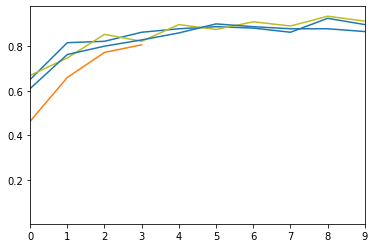

In [2]:
#import sys
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install hyperopt

import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # no change to model architecture??? WHat that mean anyway
        self.conv1 = nn.Conv2d(1,3, kernel_size=3)
        self.fc = nn.Linear(192,10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total
    
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")
                
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9)
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

analysis = tune.run(train_mnist, config=search_space)

dfs = analysis.trial_dataframes
[d.mean_accuracy.plot() for d in dfs.values()]

analysis = tune.run(
    train_mnist,
    num_samples=20,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
    
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", 1e-10, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

analysis = tune.run(train_mnist, num_samples=10, search_alg=hyperopt_search)

# To enable GPUs, use this instead:
# analysis = tune.run(
#     train_mnist, config=search_space, resources_per_trial={'gpu': 1})

import os

df = analysis.results_df
logdir = analysis.get_best_logdir("mean_accuracy", mode="max")
state_dict = torch.load(os.path.join(logdir, "model.pth"))

model = ConvNet()
model.load_state_dict(state_dict)